# Water box

### **Hello, water box! 1_water_box in the tutorial files**  
- Generate a water box in a 5-nm cube  
`gmx solvate -box 5 5 5 -cs -o 1.pdb`  
`-box`: box dimension  
`-cs`: type of water. By default, a 3-point water type.  
`-o`: output file name  


- Open the output file using a text editor and see the format of PDB file  
- How many water molecules do we have in this 5-nm cubic box?  
    - Log message will tell the number.  
    - Otherwise, we can count by using wc command  
    - `grep OW 1.pdb | wc -l`  

- Use VMD to see the water box.

### **Input files for MD simulation**
#### `topol.top`: topology file  
- topol. top file contains information of force field and the simulation system.  
- copy files/topol.top to PWD (present working directory)  
    `cp files/topol.top .`  ("." indicates the current directory.)
- A reusable part can be saved in a separate file, which can included in topol.top  
    `#include REUSABLE_FILE`  
- To see the installed force fields, see `$GMXDATA/top` directory  
    `ls $GMXDATA/top`  
- In this example, we will use amber99sb.ff.  
    - `amber99sb.ff/forcefield.itp` contains files with all force field parameters.  
        See the files that `forcefield.itp` includes.  
    - `amber99sb.ff/tip3p.itp` contains "`moleculetype`" definition for the TIP3P water model.


#### `grompp.mdp`: MD Option file  
- MDP file contains MD simulation Options.
    See https://manual.gromacs.org/current/user-guide/mdp-options.html for details.  
- Copy a sample MDP file to PWD (present working directory)  
    `cp files/*.mdp .`  
- Open grompp.mdp using a text editor  
    See each section of the file.

### **The first MD simulation**  
#### `topol.tpr`: Input file for MDRUN  
- Now, we have all input files for simulation:  
    - Structure file: 1.pdb  
    - `topol.top`  
    - `grompp.mdp`  
- gmx grompp program assembles information from all three files into a topol.tpr file  
    - `gmx grompp -f grompp.mdp -c 1.pdb -p topol.top -pp processed.top  -o topol.tpr`  
        `-pp`: write the topology file interpreted by grompp. It writes a long file with all the parameters in a single file without using #include.  
- topol.tpr is a binary file.   
    - To see the content of topol.tpr use gmx dump command.
    - `gmx dump -s topol.tpr`

#### The first MDRUN  
- Now, we perform MD by gmx mdrun program  
    - `gmx mdrun -nt 4 -gpu_id 0`
        - `-nt`: the number of CPU cores for this run.  
        - `-gpu_id`: GPU ID for this run if you have GPU in your system, 0, 1, 2, etc. If you have only one GPU in the system, use 0 or omit this option.  
- The simulation will fail because LJ interaction forces are too high (i.e., too much acceleration).  
    - see `md.log` file  
        - It is important to check the energy values  
        - In normal MD simulations in a water box, the total energy of the system should be a huge negative value.

### **Minimize the system**  
- Prepare a new topol.tpr file for minimization:  
    - `gmx grompp -f mini.mdp -c 1.pdb`  
        - Compare mini.mdp with grompp.mdp:  
            - diff mini.mdp grompp.mdp  
    - `gmx mdrun -nt 4 -gpu_id 0 -c 2.pdb`  
        - `-c`: The minimized system will be written to 2.pdb  
    - see `md.log` and `ener.edr` files to see change in energy.  
        - `gmx energy -f ener.edr`

### **Try MD again**  
- Open `grompp.mdp` and change the settings:  
    ```bash
    nsteps                   = 2500  ; Do MD for 2500 steps
    nstxout-compressed       = 1     ; write trajectory every step.
    ```
    
- Generate topol.tpr  
    - `gmx grompp -c 2.pdb -f grompp.mdp`  
        - `-c`: Now, we are using the minimized structure.  
- Perform MD.  
    - `gmx mdrun -nt 4 -gpu_id 0`  
        -  it will generate some output files:  
            - `md.log` : text log file  
            - `ener.edr` : binary energy file  
            - `traj_comp.xtc` : trajectory file  
            - `state.cpt` : check point file for continuation  
- See `traj_comp.xtc` using VMD  
    - `traj_comp.xtc` will look weird because water molecules at the boundary are broken.  
    - This happens because gmx mdrun wants to have all atoms in a unit cell.
- We can fix this by using `gmx trjconv`  
    - `gmx trjconv -f traj_comp.xtc -pbc mol -ur compact -o tmp1.xtc`  
    - Load tmp1.xtc to VMD, and see the difference.
- We can fix PDB file using `gmx trjconv`  
    - `2.pdb` file has broken water molecules because it is an output from `gmx mdrun`.  
    - `gmx trjconv -f 2.pdb -pbc mol -ur compact -o 2.pdb`  
- To prevent molecules from box crossing, use `-pbc nojump` option.
    - `gmx trjconv -s 1.pdb -f traj_comp.xtc -pbc nojump -o tmp2.xtc`  
        - the starting conformation should be whole. `1.pdb` file in this case.

### **MD for 10 ns**  
- Change grompp.mdp:  
    ```bash
    nsteps                   = 5000000  ; 10 ns  
    nstxout-compressed       = 10000    ; write trajectory every 20 ps
    ```
- `gmx grompp -c 2.pdb -f grompp.mdp`  
- `gmx mdrun -nt 4 -gpu_id 0 -cpi -noappend`  

- check box size and temperature  
    - `gmx traj -ob -f traj_comp.part0002.xtc`  
        - see `box.xvg`  
    - `gmx energy -f ener.part0002.edr`  
        - see `energy.xvg`  

### **Structural properties of water: Radial distribution function, g(r)**  
- g(r) tells the average spatial distribution (or probability) with respect to a particle.  
    - g(r) is unitless and converges to 1 at large r.  
    - Number of particles at rdr equals  
        - g(r) * 4 pi rdr * average_number_density
    - g(r) can tell most thermodynamic and structural properties of simple liquid.  
    - for example, G(r) = -kT ln g(r)
#### Calculation of g(r) using Gromacs  
-  The analysis group here is oxygen atoms.  
    - i.e., we want to calculate the distribution of O-O distance.  
- Generate an index file using gmx make_ndx
    - gmx make_ndx -f topol.tpr -o rdf.ndx  
        - Index file (ndx) is just a collection of atom indices.  
        - Default groups do not have oxygen atom groups.  
        - Select oxygens: `a O*`
        - And quit: `q`
- Calculate g(r) using gmx rdf  
    - gmx rdf -f traj_comp.part0002.xtc -n rdf.ndx -o -cn
        - Select "O*" group as a reference group
        - Select "O*" group as an analysis group.
        - ctrl+D to tell gmx rdf that you're done selction.

    - see rdf.xvg and rdf_cn.xvg files.  
    - Plot rdf.xvg and rdf_cn_xvg using xmgrace or gnuplot.  
    - Plot g(r) using gnuplot.  
        - Run gnuplot by typing gnuplot in your terminal.  
            - If you are not familiar with gnuplot, you can download rdf.xvg file and plot it using other programs such as Excel, Origin etc.  
        - Type the followings in your gnuplot session:  
            ```bash
            # If you didn't set X11 forwarding (e.g., VS code), you won't be able to see the plot.
            # In this case you can save the plot to an image file.
            # do the following if you want to forward the output to an image.
            set terminal png
            set output "myplot.png"	# output will be saved to myplot.png file.
            set xlabel "r (nm)"
            set ylabel "g(r)"
            set grid
            pl [0:1] 'rdf.xvg' u 1:2 w l
            ```

#### You can also plot with python.

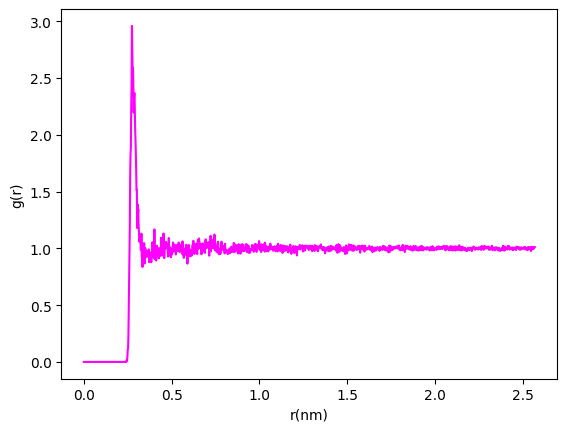

In [26]:
import numpy as np
import matplotlib.pyplot as plt


# Path to your rdf.xvg file
file_path = f"/home/wowjason/work/projects/md_lect/1_water_box/newbox/rdf.xvg"

rdf_xvg = np.loadtxt(file_path, comments=["#", "@"])
r = rdf_xvg[:, 0]
rdf= rdf_xvg[:, 1]

plt.figure()
plt.plot(r, rdf, color="magenta")
plt.xlabel("r(nm)")
plt.ylabel("g(r)")
plt.show()


#### The relationship between g(r) and the free energy G(r)  
- g(r) is related to the free energy G(r) by G(r) = -kT ln g(r).  
    - Plot G(r) using gnuplot  
        ```bash
        set xlabel "r (nm)"
        set ylabel "Energy (kT)"
        set grid
        pl [0:1][-1:2] 'rdf.xvg' u 1:(-log($2)) w l
        ```
        - The curve shows the average interaction free energy between water molecules.  



#### You can also plot with python

/tmp/ipykernel_816300/1270754765.py:4: RuntimeWarning: divide by zero encountered in log
  free_energy = -2.5 * np.log(rdf)


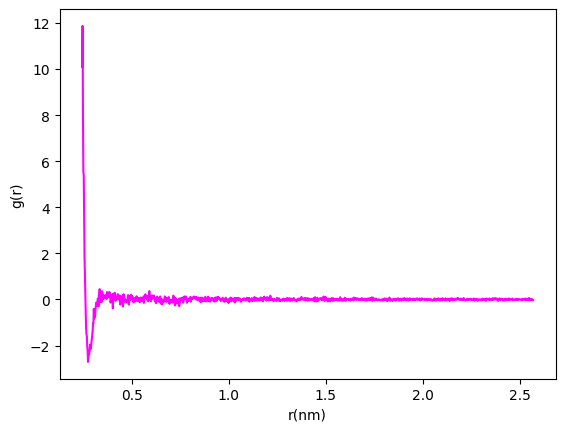

In [ ]:
from scipy.constants import k

free_energy = -2.5 * np.log(rdf)

plt.figure()
plt.plot(r, free_energy, color="magenta")
plt.xlabel("r(nm)")
plt.ylabel("g(r)")
plt.show()

#### Calculation of g(r) using VMD  -> try

### **Potential of mean force by Umbrella sampling**  
- g(r) tells us the ensemble-averaged interaction for water pairs.  
    - This is possible we can sample an ensemble of water configurations sufficiently.  
        - In other words, this is now a rare event.  
    - But, to calculate interaction ∆G for the hard-to-sample pairs, we need a technique that makes sampling rare events possible.  
        - Umbrella sampling.  

#### Umbrella sampling  
- First, we need to select two water molecules, for which we want to calculate intermolecular interaction free energy.  
    - The chance that these two specific water molecules meet is RARE!  
        - Thus, it will take a very long time to sample the rare events sufficiently.  
    - In umbrella sampling, we constraint the water-water pair by using a harmonic spring.  
        - See PULL section in MDP options.  
    - Generate index file for two water molecules  
        - We will just select the first and the second water molecules. The selection will not change the results. All water molecules are equal!  
        `gmx make_ndx -f topol.tpr -o pull.ndx`  
        `ri 1`  
        `ri 2`  
        `q`  
        - Caution: The initial distance between chosen water molecules must be smaller than half of the box. Otherwise, it violated PBC.  


#### Perform simulation in each window  
- 0.2 nm window  
    - See PULL section in pull.02.mdp  
        ```bash
        pull-ngroups             = 2
        pull-ncoords             = 1
        pull-group1-name         = r_1
        pull-group2-name         = r_2
        pull-coord1-type         = umbrella
        pull-coord1-geometry     = distance
        pull-coord1-groups       = 1 2
        pull-coord1-dim          = Y Y Y
        pull-coord1-init         = 0.2              ; the equilibrium length of spring is 0.2 nm
        pull-coord1-k            = 1000             ; spring constant in kJ/mol nm
        ```
- Generate pull.02.tpr for gmx mdrun  
    `gmx grompp -c 2.pdb -f pull.02.mdp -n pull.ndx -o pull.02.tpr -t state.cpt`  
        - `-t state.cpt`: use information from the check point file.  
- Perform MDRUN for 1 ns  
    - `gmx mdrun -s pull.02.tpr -nt 4 -gpu_id 0 -cpi -noappend -deffnm pull.02 -nsteps 500000`  
        - pullx files contain the length of spring  
        - pullf files contain the force on the spring (F = -kx)  
        - CAUTION: If the initial distance between two pull groups is longer than the half the box size, mdrun will die returning corresponding error messages.  
            - In this case, one can rearrange the order of water molecules in the initial structure file using text editors such that the pull groups (the first and the second water molecules in this example) are close each other. Note that the order of appearance of water molecules will not change the MD simulation.   
    
- Repeat same things for other windows  
    ```
    for i in 03 04 05 06 07 08 09 10; do  
        gmx grompp -c 2.pdb -f pull.$i.mdp -n pull.ndx -o pull.$i.tpr  
        gmx mdrun -s pull.$i.tpr -nt 4 -gpu_id 0 -cpi -noappend -deffnm pull.$i -nsteps 500000  
    done
    ```

### **Weighted Histogram Analysis Method (WHAM)**
- Umbrella potentials force sampling rare events.  
- But, the effect of umbrella potentials must be removed to get G(r).  
- Weighted histogram analysis method (WHAM) is a method that reconstructs G(r) by iteratively removing the effect of Umbrella potentials.  
- `gmx wham` is the  Gromacs implemenation.  
#### gmx wham
- `gmx wham` requires two input files:  
    - list of pullx files  
        - `ls pull.*pullx.xvg > pullx-files.dat`  
    - list of tpr files  
        - `ls pull*tpr > tpr-files.dat`  
    - `pullx-files.dat` and `tpr-files.dat` must be ordered in the same way.  
        - `gmx wham -ix pullx-files.dat -it tpr-files.dat -bins 50`  
            - Outputs:  
                - `profile.xvg`  
                - `histo.xvg`  
    - `histo.xvg` contains histogram (or probability distribution) of each window.  
    - Plot histograms of all windows using gnuplot  
        ```bash
        set xlabel "r (nm)"
        set ylabel "Probability"
        set grid

        pl 'histo.xvg' u 1:2 w l title "Window r = 0.2 nm" ,\
        'histo.xvg' u 1:3 w l title "Window r = 0.3 nm" ,\
        'histo.xvg' u 1:4 w l title "Window r = 0.4 nm" ,\
        'histo.xvg' u 1:5 w l title "Window r = 0.5 nm" ,\
        'histo.xvg' u 1:6 w l title "Window r = 0.6 nm" ,\
        'histo.xvg' u 1:7 w l title "Window r = 0.7 nm" ,\
        'histo.xvg' u 1:8 w l title "Window r = 0.8 nm" ,\
        'histo.xvg' u 1:9 w l title "Window r = 0.9 nm" ,\
        'histo.xvg' u 1:10 w l title "Window r = 1.0 nm"
        ```

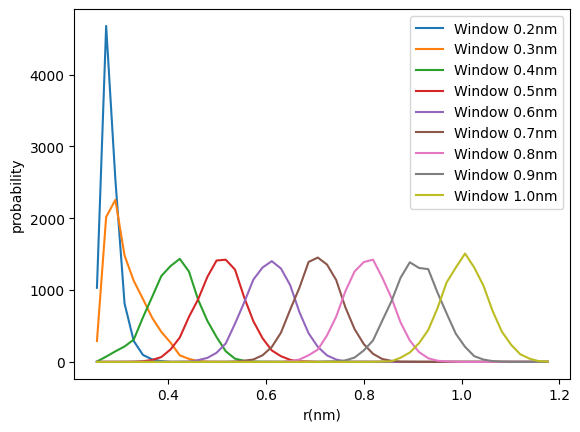

In [24]:
file_path = f"/home/wowjason/work/projects/md_lect/1_water_box/newbox/histo.xvg"

probs = np.loadtxt(file_path, comments=["#", "@"])
r = probs[:, 0]

plt.figure()
for i in range(1, 10):
    plt.plot(r, probs[:, i], label=f"Window {(0.1 * (i+1)):.1f}nm")
plt.xlabel("r(nm)")
plt.ylabel("probability")
plt.legend()
plt.show()


- `profile.xvg` file contains ∆G curve as a function of r.  
- Compare g(r) and ∆G using gnuplot  
    ```bash
    set xlabel "Distance r (nm)"
    set ylabel "Energy (kJ/mol nm)"
    set grid
    pl [0:1] 'rdf.xvg' u 1:(-2.5 * log($2)) w l title "-kT ln g(r)", 'profile.xvg' u 1:($2+9) w l title "Delta G from WHAM", 'profile.xvg' u 1:($2 + 2*2.5*log($1) +8.5) w l title "Delta G corrected by 2kT*ln(r)"
    ```
    - Note that kT ~ 2.5 kJ/mol nm ~ 0.6 kcal/mol  
    - These are free energy difference ∆G(r), not the absolute free energy G(r). Thus, we can shift the curves by adding a constant.  
    - What does 2 x 2.5 x log($1) do?  

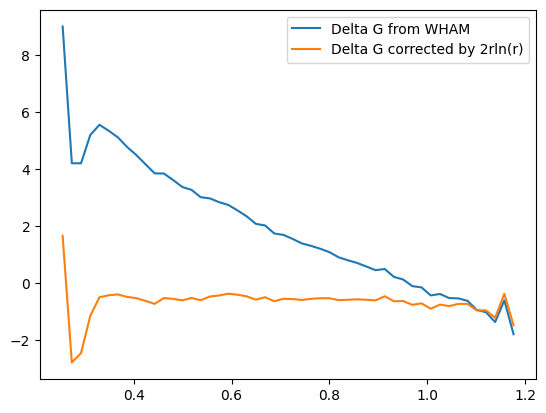

In [47]:
file_path = f"/home/wowjason/work/projects/md_lect/1_water_box/newbox/profile.xvg"

profile = np.loadtxt(file_path, comments=["#", "@"])
r = profile[:, 0]

delta_g_from_wham = profile[:, 1] + 9
delta_g_corrected = profile[:, 1] + 5.0 * np.log(profile[:, 0]) + 8.5

plt.figure()
plt.plot(r, delta_g_from_wham, label="Delta G from WHAM")
plt.plot(r, delta_g_corrected, label="Delta G corrected by 2rln(r)")
plt.legend()
plt.show()

#### Discussions
- How to estimate error?  
    - `gmx wham` has bootstrap options.  
    - More straightforward way is getting multiple results (or splitting simulation into multiple blocks) and calculate stardard errors.  
- How can we tell if the Umbrella sampling is long enough?  
    - For many real problems, very long simulations are necessary.  
        - Keep continuing each window.  
        - When you have multiple pullx files for a window, you need to combine them into a pullx file. For example, awk command.  
        - Calculate `gmx wham` frequently.  
            - If PMF converges (i.e., PMF does not change any more), quit.  
            - Otherwise, keep simulating.  

### **Dynamic properties of water: Diffusion**
- Mean squared displacement (MSD) = 6D∆t  
- `gmx msd -f traj_comp.part0002.xtc -n rdf.xvg`

### **Homework**
#### What is the plot for mean forces as a function of distance?  
- Plot the mean force <F> in each window. Simply get the average over time for each pullf file.  
- One can get ∆G as a function of r by integrating the mean force <F> with respect to r.  
    - Compare three  PMF curves (∆G curves) from g(r), WHAM, and the integration of mean forces.  
#### What is the pairwise interaction free energy between a pair of Na and Cl ions?  
- Add a pair of Na and Cl to water box.  
- You can do it manually using a text editor:  
    - Change two water molecules to Na and Cl ions.  
    - Change `topol.top` accordingly  
        ```bash
        [ system]
        SOL                  NNNN        ; the number of SOL must be decreased by 2
        Na                     1
        Cl                     1
        ```
- Repeat the umbrella sampling for the Na-Cl pair  
- Repeat WHAM
#### Try different water models such as OPC, TIP4P etc.